In [150]:
import numpy as np
from pathlib import Path

# Get project root directory by looking for a .pendulum_nn_root file
def find_project_root(start_path):
    current_path = Path(start_path).resolve()
    while current_path != current_path.parent:  # Traverse up to the root
        if (current_path / ".pendulum_nn_root").exists():
            return current_path
        current_path = current_path.parent
    raise FileNotFoundError(".pendulum_nn_root file not found in any parent directory.")

# Use the current working directory as the starting point
project_root = find_project_root(Path.cwd())
print(f"Project root directory: {project_root}")

Project root directory: /Users/jare/Documents/Personal projects/Pendulum NN/pendulum-nn


In [151]:
# Path to the logs directory with Path
logs_dir = project_root / "logs"

# Find all subfolders in logs dir
subfolders = [f for f in logs_dir.iterdir() if f.is_dir()]

# Remove "decay" from subfolders if it exists
decay_folder = logs_dir / "decay"
if decay_folder in subfolders:
    subfolders.remove(decay_folder)

impulse_strength_labels = [folder.name for folder in subfolders]
impulse_strength_labels.sort(key=lambda x: float(x))

print(f"Impulse strength labels: {impulse_strength_labels}")

Impulse strength labels: ['0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50', '1.60', '1.70', '2.00']


In [152]:
raw_segments_by_impulse = {}

for folder in subfolders:
    impulse_strength = folder.name
    # Find all .npz files in the logs directory
    log_files = sorted(folder.glob("*.npz"))

    # Initialize a list to store segments
    peaks = []
    timestamps = []

    # Concatenate all segments from the log files
    for log_file in log_files:
        data = np.load(log_file)
        peaks.extend(data["peaks"])
        timestamps.extend(data["timestamps_ms"])
        
    peaks = [int(x) for x in peaks]
    timestamps = [int(x) for x in timestamps]
    
    raw_segments_by_impulse[impulse_strength] = {"peaks": peaks, "timestamps_ms": timestamps}
    # Display the total number of segments and a preview of the first segment
    print(f"Total number of data points for {impulse_strength}: {len(peaks)}")

Total number of data points for 0.90: 521
Total number of data points for 1.00: 603
Total number of data points for 1.30: 773
Total number of data points for 1.70: 0
Total number of data points for 1.40: 832
Total number of data points for 1.50: 839
Total number of data points for 1.60: 709
Total number of data points for 2.00: 1122
Total number of data points for 1.20: 1484
Total number of data points for 1.10: 740
Total number of data points for 0.80: 507


In [153]:
#Average of all peaks across all impulse strengths
raw_segments = []
for segment in list(raw_segments_by_impulse.values()):
    raw_segments.extend(segment["peaks"])

average_peak = np.mean(raw_segments)
print(f"Total number of peaks across all segments: {len(raw_segments)}")
print(f"Average peak value across all segments: {average_peak}")

baseline = round(average_peak)

all_adjusted_peaks = [x - baseline for x in raw_segments]

Total number of peaks across all segments: 8130
Average peak value across all segments: -386.31439114391145


## Distributions

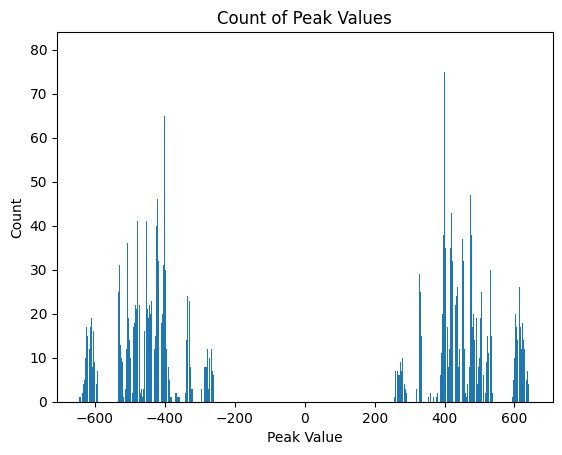

In [154]:
# Get count of unique adjusted peak values
unique, counts = np.unique(all_adjusted_peaks, return_counts=True)
peak_distribution = dict(zip(unique, counts))

#Plot bar chart of adjusted peaks
import matplotlib.pyplot as plt

plt.bar(unique, counts)
plt.xlabel("Peak Value")
plt.ylabel("Count")
plt.title("Count of Peak Values")
plt.show()

## Apply global offset to readings

In [155]:
adjusted_segments_by_impulse = {}

for impulse_strength, segment in raw_segments_by_impulse.items():
    adjusted_peaks = [x - baseline for x in segment["peaks"]]
    adjusted_segments_by_impulse[impulse_strength] = {
        "peaks": adjusted_peaks,
        "timestamps_ms": segment["timestamps_ms"]
    }

## Amplitude vs impulse strength

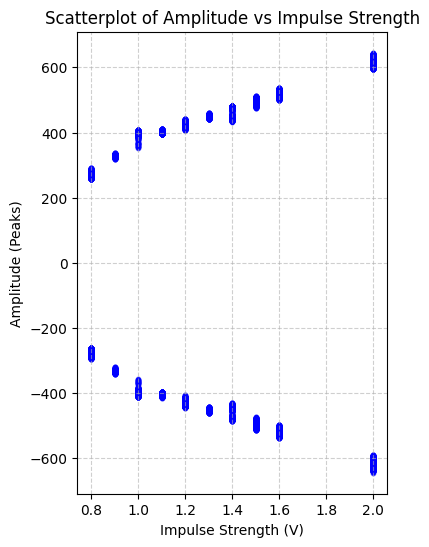

In [159]:
# Scatterplot of all values: x = impulse strength, y = amplitude
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store data for the scatterplot
x = []
y = []

# Collect data from all impulse strengths
for impulse_strength in impulse_strength_labels:
    if impulse_strength in adjusted_segments_by_impulse:
        segment = adjusted_segments_by_impulse[impulse_strength]
        peaks = segment["peaks"]

        # Add impulse strength and corresponding peaks to the lists
        x.extend([float(impulse_strength)] * len(peaks))
        y.extend(peaks)

# Create the scatterplot
plt.figure(figsize=(4, 6))
plt.scatter(x, y, alpha=0.6, s=10, c="blue")
plt.xlabel("Impulse Strength (V)")
plt.ylabel("Amplitude (Peaks)")
plt.title("Scatterplot of Amplitude vs Impulse Strength")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()